<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
#загружаем необходимые библиотеки
import pandas as pd

from sklearn.preprocessing import StandardScaler

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve  

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("/datasets/Churn.csv")

In [3]:
data.shape

(10000, 14)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
data.columns = data.columns.str.lower()

In [6]:
data.head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


*Целевой признак* Exited — факт ухода клиента. Будем решать задачу методами классификации. 

In [7]:
#заменим пропуски в колонке 
data['tenure'] = data['tenure'].fillna(-1)

In [8]:
#удалим колонки с индивидуалльными характеристиками пользователей
data.drop(["rownumber", "customerid", "surname"], axis=1, inplace=True)

In [9]:
#посмотрим какие значения есть в столбце geography
data['geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

**Подготовим данные методом Onehot encoding**

In [10]:
data = pd.get_dummies(data, drop_first=True)

In [11]:
data.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


**Деление данных на выборки: обучающая, валидационная, тестовая**

In [12]:
features = data.drop('exited', axis=1)
target = data['exited']

In [13]:
features_train, features_test0, target_train, target_test0 = train_test_split(features, target, 
                                                                              test_size=0.4, 
                                                                              random_state=1)

In [14]:
features_valid, features_test, target_valid, target_test = train_test_split(features_test0, target_test0, 
                                                                              test_size=0.5, 
                                                                              random_state=1)

In [15]:
print(features_train.shape, target_train.shape, features_valid.shape, target_valid.shape, features_test.shape, target_test.shape)


(6000, 11) (6000,) (2000, 11) (2000,) (2000, 11) (2000,)


- Обучающая выборка - 60% (`features_train`, `target_train`)
- Валидационная выборка - 20% (`features_valid`, `target_valid`)
- Тестовая выборка - 20% (`features_test`,`target_test`)

 **Масштабируем признаки**

In [16]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'estimatedsalary']

In [17]:
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])

In [18]:
features_valid[numeric] = scaler.transform(features_valid[numeric])

In [19]:
features_test[numeric] = scaler.transform(features_test[numeric])

## Исследование задачи

Проведем обучение трех моделей: DecisionTreeClassifier, RandomForestClassifier, LogisticRegression

In [20]:
model_dtc = DecisionTreeClassifier(random_state=123)
model_dtc.fit(features_train, target_train)
predictions_dtc = model_dtc.predict(features_valid)

print("Accuracy:", accuracy_score(predictions_dtc, target_valid))
print("F1:", f1_score(predictions_dtc, target_valid))
print("AUC-ROC:", roc_auc_score(target_valid, predictions_dtc))

Accuracy: 0.779
F1: 0.48842592592592593
AUC-ROC: 0.6771296063686238


In [21]:
model_rfc = RandomForestClassifier(random_state=123)

param_grid = { 
    'n_estimators': [10, 20, 30, 40, 50],
    'max_features': ['log2'],
    'max_depth' : [5,7,9,11,13,15],
    'criterion' : ['gini']
}

CV_rfc = GridSearchCV(estimator=model_rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(features_train, target_train)


predictions_rfc = CV_rfc.best_estimator_.predict(features_valid)
print("accuracy:", accuracy_score(predictions_rfc, target_valid))
print("F1:", f1_score(predictions_rfc, target_valid))
print("AUC-ROC:", roc_auc_score(target_valid, predictions_rfc))

accuracy: 0.865
F1: 0.5794392523364486
AUC-ROC: 0.7098196489254


In [22]:
model_lgr = LogisticRegression(solver = 'liblinear')
model_lgr.fit(features_train, target_train)

predictions_lgr = model_lgr.predict(features_valid)

print("Accuracy:", accuracy_score(predictions_lgr, target_valid))
print("F1:", f1_score(predictions_lgr, target_valid))
print("AUC-ROC:", roc_auc_score(target_valid, predictions_lgr))

Accuracy: 0.8105
F1: 0.3315696649029982
AUC-ROC: 0.5951728370732853


Точность и  F1-метрика:
- дерево решений 0.779 и 0.488
- случайный лес  0.865 и 0.579
- логистческая регрессия 0.805 и 0.331

Наиболее высокими показателями обладает модель случйного леса.

## Борьба с дисбалансом

In [23]:
target_train.value_counts(normalize = 1)

0    0.800667
1    0.199333
Name: exited, dtype: float64

In [24]:
target_valid.value_counts(normalize = 1)

0    0.7895
1    0.2105
Name: exited, dtype: float64

У обучающией и валидационной выборок наблюдается заметный дисбаланс класов. Ответы 0 ≈ 80% , 1 ≈ 20%


**Upsampling**

In [25]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled_train, target_upsampled_train = upsample(features_train, target_train, 4)

<AxesSubplot:ylabel='Frequency'>

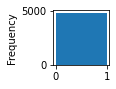

In [26]:
target_upsampled_train.plot(kind ='hist', bins=2, figsize=(1,1))

In [27]:
CV_rfc = GridSearchCV(estimator=model_rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(features_upsampled_train, target_upsampled_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             param_grid={'criterion': ['gini'],
                         'max_depth': [5, 7, 9, 11, 13, 15],
                         'max_features': ['log2'],
                         'n_estimators': [10, 20, 30, 40, 50]})

In [28]:
predictions = CV_rfc.best_estimator_.predict(features_valid)


print("Accuracy:", accuracy_score(predictions, target_valid))
print("F1:", f1_score(predictions, target_valid))
print("AUC-ROC:", roc_auc_score(target_valid, predictions))

Accuracy: 0.8425
F1: 0.6067415730337079
AUC-ROC: 0.7452166875514283


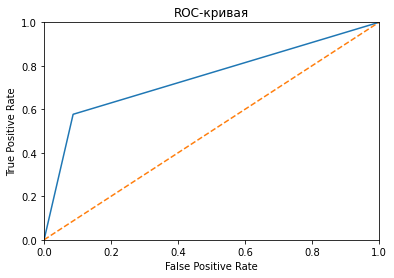

In [29]:
fpr, tpr, thresholds = roc_curve(target_valid, predictions) 
plt.figure()

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

**Downsampling**

In [30]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=123)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=123)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=123)
    
    return features_downsampled, target_downsampled

In [31]:
features_downsampled_train, target_downsampled_train = downsample(features_train, 
                                                                  target_train, 
                                                                  fraction=0.1)


In [32]:
CV_rfc_down = GridSearchCV(estimator=model_rfc, param_grid=param_grid, cv=5)
CV_rfc_down.fit(features_downsampled_train, target_downsampled_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             param_grid={'criterion': ['gini'],
                         'max_depth': [5, 7, 9, 11, 13, 15],
                         'max_features': ['log2'],
                         'n_estimators': [10, 20, 30, 40, 50]})

In [33]:
predictions = CV_rfc_down.best_estimator_.predict(features_valid)
print("Accuracy:", accuracy_score(predictions, target_valid))
print("F1:", f1_score(predictions, target_valid))
print("AUC-ROC:", roc_auc_score(target_valid, predictions))

Accuracy: 0.563
F1: 0.47094430992736086
AUC-ROC: 0.6953708035543708


Обучение модели Random forest на сбалансированной выборке (техника upsampling) привело к повышению метрик. Далее проверим модель на тестовой выборке.

## Тестирование модели

In [34]:

predictions = CV_rfc.best_estimator_.predict(features_test)
print("Accuracy:", accuracy_score(predictions, target_test))
print("F1:", f1_score(predictions, target_test))
print("AUC-ROC:", roc_auc_score(target_test, predictions))

Accuracy: 0.852
F1: 0.6105263157894737
AUC-ROC: 0.7420132610006027


**Выводы**
- Провели подготовку данных: удалили лишние признаки, заполнили пропуски, масштабировали численные признаки, применили технику OHE для категориальных признаков 
- Исследовали задачи на трех моделях. Наиболее точной оказалась модель случайного леса с метрикой F1=0.58
- Выявили дисбаланс классов 80/20 (отрицательные/положительные). Произвели upsampling положительного класса, благодаря чему удалось повысить F1 до 0.61. Dowmsampling оказался менее эффективен.
- Проверка на тестовой выборке показала, что модель обученной на upsampling данных показывает: точность 0.852, F1 0.61, AUC-ROC 0.74


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: задача исследована
    - [ ]  Исследован баланс классов
    - [ ]  Изучены модели без учёта дисбаланса
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 3: учтён дисбаланс
    - [ ]  Применено несколько способов борьбы с дисбалансом
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 4: проведено тестирование
- [ ]  Удалось достичь *F1*-меры не менее 0.59
- [ ]  Исследована метрика *AUC-ROC*